In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import sklearn
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\mitsh\\.keras\\datasets\\auto-mpg.data'

In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [4]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [5]:
dataset = dataset.dropna()

In [6]:
dataset['Origin'] = dataset['Origin'].map(lambda x: {1: 'USA', 2: 'Europe', 3: 'Japan'}.get(x))

In [7]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [8]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

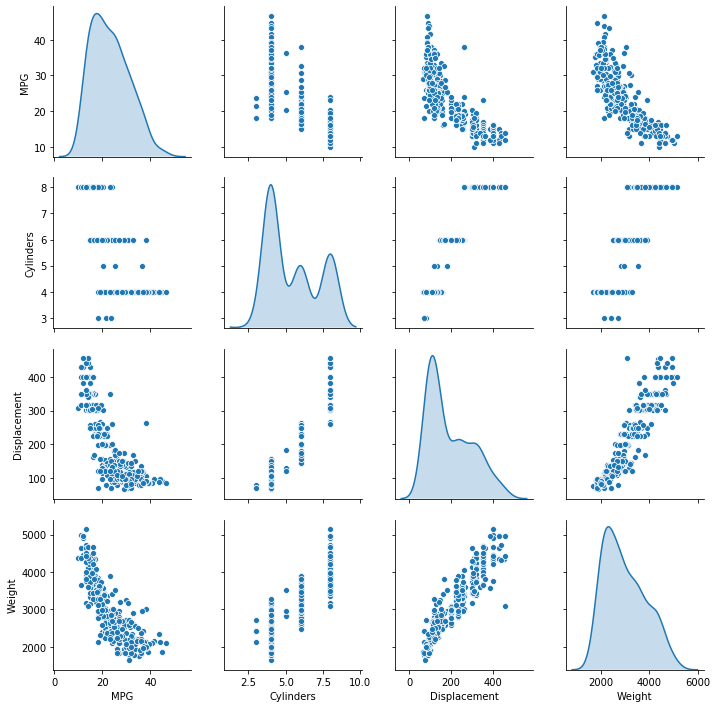

In [9]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [10]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [11]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [12]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [13]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [14]:
model = build_model()

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [16]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.30620295],
       [-0.35887718],
       [-0.24213834],
       [-0.4485308 ],
       [-0.43625283],
       [-0.23506534],
       [-0.37890142],
       [-0.18929559],
       [-0.15114911],
       [-0.42991835]], dtype=float32)

In [17]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:587.9005,  mae:22.9486,  mse:587.9005,  val_loss:582.3012,  val_mae:22.7513,  val_mse:582.3012,  
....................................................................................................
Epoch: 100, loss:6.1261,  mae:1.7392,  mse:6.1261,  val_loss:9.4349,  val_mae:2.3622,  val_mse:9.4349,  
....................................................................................................
Epoch: 200, loss:5.4207,  mae:1.6255,  mse:5.4207,  val_loss:8.8294,  val_mae:2.2993,  val_mse:8.8294,  
....................................................................................................
Epoch: 300, loss:4.6559,  mae:1.5006,  mse:4.6559,  val_loss:9.1403,  val_mae:2.3052,  val_mse:9.1403,  
....................................................................................................
Epoch: 400, loss:4.0546,  mae:1.4213,  mse:4.0546,  val_loss:9.0521,  val_mae:2.3073,  val_mse:9.0521,  
..............................................................

In [18]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.140378,0.997811,2.140378,7.626481,2.147169,7.626481,995
996,2.119262,0.948001,2.119262,7.935531,2.145727,7.935531,996
997,2.220702,1.002778,2.220702,7.929035,2.141600,7.929035,997
998,2.248801,0.967901,2.248801,7.928865,2.155559,7.928865,998
999,2.045228,0.935337,2.045228,7.712487,2.141448,7.712487,999


In [19]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

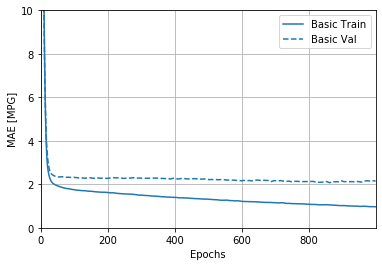

In [20]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

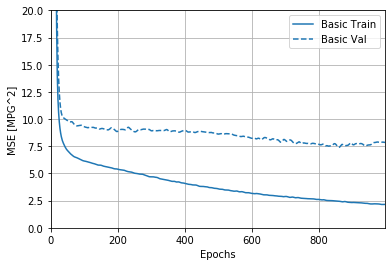

In [21]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

In [22]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:573.1214,  mae:22.6649,  mse:573.1214,  val_loss:561.2828,  val_mae:22.4024,  val_mse:561.2828,  
.......................................................................

Text(0, 0.5, 'MAE [MPG]')

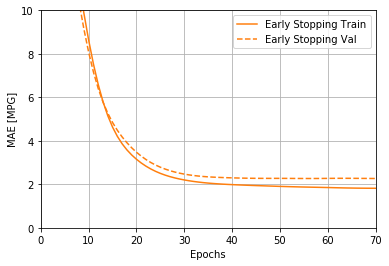

In [23]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [24]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.5150 - mae: 1.7857 - mse: 5.5150
Testing set Mean Abs Error:  1.79 MPG


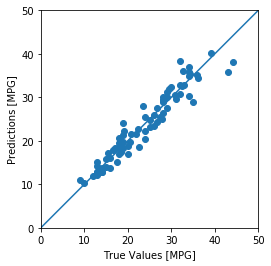

In [25]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

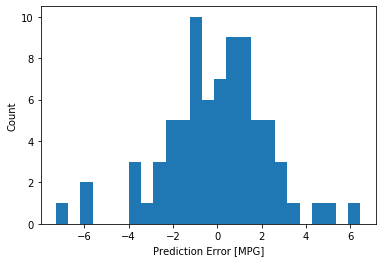

In [26]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

In [27]:
from sklearn.ensemble import RandomForestRegressor

In [28]:
X_df= dataset[['Cylinders','Displacement','Horsepower','Weight','Acceleration']]
Y_df= dataset[['MPG']]
from sklearn.preprocessing import LabelEncoder
for column in dataset:
    if dataset[column].dtype == type(object):
        le = sklearn.preprocessing.LabelEncoder()
        dataset[column] = le.fit_transform(dataset[column])
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_df,Y_df)

In [29]:
m_rf = RandomForestRegressor(n_estimators=1000)
m_rf.fit(normed_train_data,train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [30]:
m_rf.score(normed_test_data,test_labels)

0.9196205754284673

In [31]:
m_rf_results = pd.DataFrame(test_labels)
m_rf_results['avg_abs_error']=m_rf.predict(normed_test_data)
m_rf_results['rf_error'] = m_rf_results['avg_abs_error']-m_rf_results['MPG']
m_rf_results.tail()

,MPG,avg_abs_error,rf_error
369,34.0,31.4109,-2.5891
375,36.0,35.1707,-0.8293
382,34.0,33.6817,-0.3183
384,32.0,36.3928,4.3928
396,28.0,30.0517,2.0517


In [32]:
m_rf_results['rf_error'].abs().mean()

1.766371794871792